In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os # accessing directory structure
import seaborn as sns
color_pal= sns.color_palette()
plt.style.use('ggplot') # make it pretty
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('Data/AEP_hourly.csv')

In [3]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [4]:
df.shape

(121273, 2)

In [5]:
df=df.set_index('Datetime')

In [6]:
df.index

Index(['2004-12-31 01:00:00', '2004-12-31 02:00:00', '2004-12-31 03:00:00',
       '2004-12-31 04:00:00', '2004-12-31 05:00:00', '2004-12-31 06:00:00',
       '2004-12-31 07:00:00', '2004-12-31 08:00:00', '2004-12-31 09:00:00',
       '2004-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=121273)

In [7]:
df.index = pd.to_datetime(df.index)

### Outlier Id

Multiple valid approaches. Visual verus a hueristic approach (+- 1.5 x IQR)

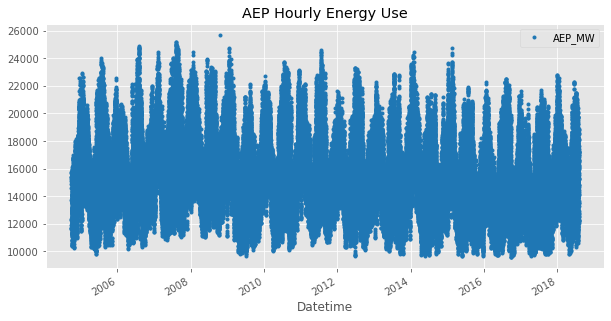

In [8]:
df.plot(style = '.',
       figsize = (10,5),
       color = color_pal[0],
       title = 'AEP Hourly Energy Use')
plt.show()

<AxesSubplot:ylabel='Frequency'>

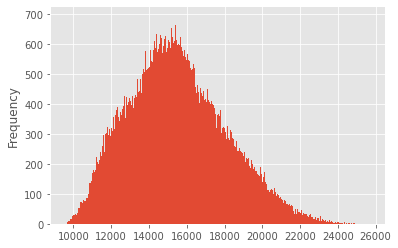

In [9]:
df['AEP_MW'].plot(kind='hist', bins=500)

<AxesSubplot:xlabel='Datetime'>

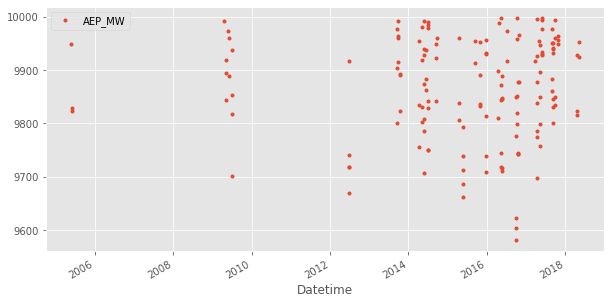

In [10]:
df.query('AEP_MW < 10000').plot(figsize = (10,5), style = '.')

<AxesSubplot:xlabel='Datetime'>

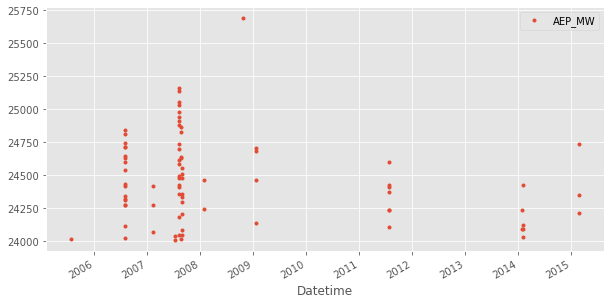

In [11]:
df.query('AEP_MW > 24000').plot(figsize = (10,5), style = '.')

Outlier removal via IQR

In [12]:
def Outlier_Limits(df):
    Q1 = df.quantile(.25)
    Q3 = df.quantile(.75)
    IQR = Q3 - Q1
    LL = Q1 - (IQR*1.5)
    UL = Q3 + (IQR*1.5)
    
    return LL, UL

In [13]:
df_outlier_limits = Outlier_Limits(df)

In [14]:
df_outlier_limits
LL = df_outlier_limits[0][0]
UL = df_outlier_limits[1][0]

In [15]:
LL, UL

(8275.0, 22555.0)

In [16]:
df = df.loc[(df['AEP_MW'] > LL) & (df['AEP_MW'] <= UL)]

## Timeseries Cross Validation

Using SKlearn Time Series Split

In [17]:
from sklearn.model_selection import TimeSeriesSplit

In [18]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

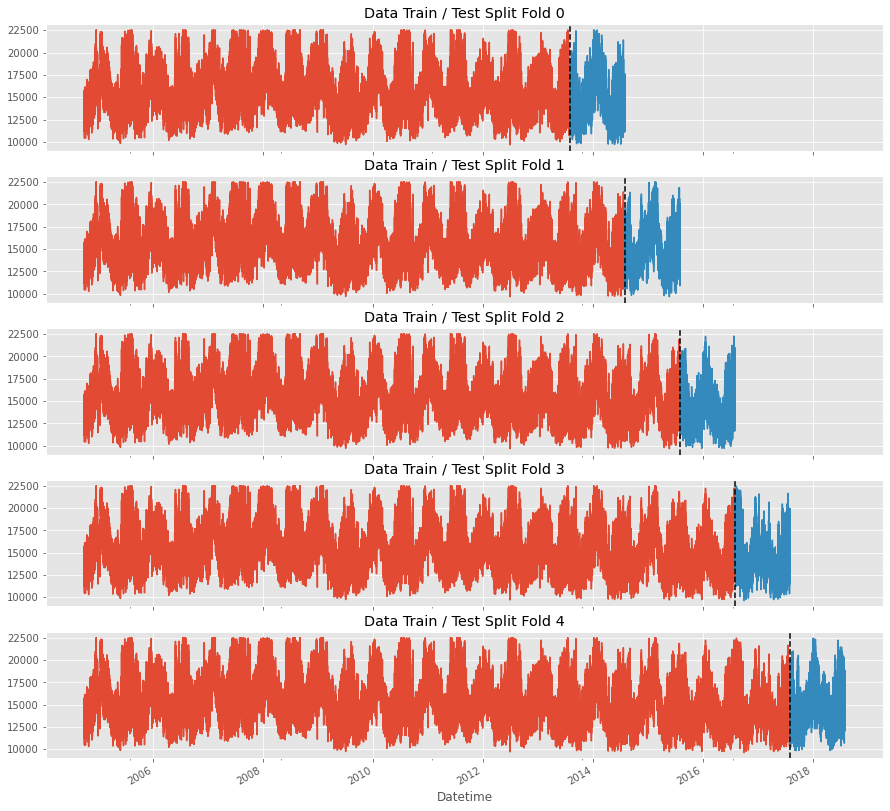

In [19]:
fig, axs = plt.subplots(5,1, figsize = (15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['AEP_MW'].plot(ax=axs[fold],
                        label = 'Training Set',
                        title = f'Data Train / Test Split Fold {fold}')
    test["AEP_MW"].plot(ax=axs[fold],
                        label = 'Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
                         

## Forecasting Horizon

In [20]:
# feature creation using datetime features
def create_dt_features(df):
    """
    create datetime features in dataframe
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [21]:
df = create_dt_features(df)

In [22]:
df

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275
...,...,...,...,...,...,...,...
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214


### Lag Features

Lag features tell the model what the target value was at a point in time and that is added as a feature

In [23]:
# create a ditionary of our target
target_map = df['AEP_MW'].to_dict()

In [24]:
def add_lags(df):
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    #df['lag5'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    return df

In [25]:
df = add_lags(df)

In [26]:
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3,lag4
Datetime,,,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,NaN,NaN,NaN,NaN
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,NaN,NaN,NaN,NaN
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,NaN,NaN,NaN,NaN
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,NaN,NaN,NaN,NaN
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,NaN,NaN,NaN,NaN


## Training using cross validation

In [27]:
df.columns

Index(['AEP_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'lag1', 'lag2', 'lag3', 'lag4'],
      dtype='object')

In [29]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0 
preds = []
scores = []
for traing_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_dt_features(train)
    test = create_dt_features(test)
    
    features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
                'lag1', 'lag2', 'lag3', 'lag4']
    target = 'AEP_MW'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree',
                      n_estimators = 1000,
                      early_stopping = 50,
                      objective = 'reg:linear',
                      max_depth = 3,
                      learning_rate = 0.01)
    reg.fit(X_train, y_train,
            eval_set = [(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[09:57:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[0]	validation_0-rmse:15545.84907	validation_1-rmse:15217.29380
[100]	validation_0-rmse:5866.53105	validation_1-rmse:5705.19238
[200]	validation_0-rmse:2534.29315	validation_1-rmse:2450.51157
[300]	validation_0-rmse:1602.58567	validation_1-rmse:1582.77691
[400]	validation_0-rmse:1406.53134	validation_1-rmse:1429.28983
[500]	validation_0-rmse:1359.60266	validation_1-rmse:1405.26989
[600]	validation_0-rmse:1339.85629	validation_1-rmse:1398.63325
[700]	validation_0-rmse:1323.62717	validation_1-rmse:1391.52594
[800]	validation_0-rmse:1311.93186	validation_1-rmse:1383.98699
[900]	validation_0-rm

In [30]:
scores

[1375.0181684336471,
 1294.74995782693,
 1302.0209165496913,
 1347.2110033656431,
 1594.4573950566735]

In [31]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'fold scores:{scores}')

Score across folds 1382.6915
fold scores:[1375.0181684336471, 1294.74995782693, 1302.0209165496913, 1347.2110033656431, 1594.4573950566735]


# Predictions

In [32]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
                'lag1', 'lag2', 'lag3', 'lag4']
target = 'AEP_MW'

X_all= df[features]
y_all = df[target]
    
reg = xgb.XGBRegressor(base_score = 0.5, booster = 'gbtree',
                  n_estimators = 700,
                  early_stopping = 50,
                  objective = 'reg:linear',
                  max_depth = 3,
                  learning_rate = 0.01)
reg.fit(X_train, y_train,
        eval_set = [(X_all, y_all)],
        verbose=100)

[10:03:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[10:03:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[0]	validation_0-rmse:15507.45048
[100]	validation_0-rmse:5858.79129
[200]	validation_0-rmse:2542.04305
[300]	validation_0-rmse:1616.15478
[400]	validation_0-rmse:1421.21724
[500]	validation_0-rmse:1375.24310
[600]	validation_0-rmse:1357.30126
[699]	validation_0-rmse:1343.23341


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping=50,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=700, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', ...)

In [33]:
fi = pd.DataFrame(data = reg.feature_importances_, index = reg.feature_names_in_, columns=['importance']) 

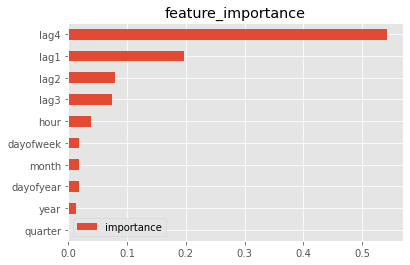

In [56]:
fi.sort_values('importance').plot(kind='barh', title='feature_importance')
plt.savefig('Images/Feature_Importance.png')
plt.show()

In [35]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [36]:
# create future dataframe

future = pd.date_range('2018-08-03', '2019-08-01', freq = '1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])

In [37]:
df_and_future = create_dt_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
df_and_future.tail()

In [38]:
future_w_features = df_and_future.query('isFuture').copy()

In [39]:
future_w_features['pred'] = reg.predict(future_w_features[features])

<AxesSubplot:title={'center':'Future Predictions'}>

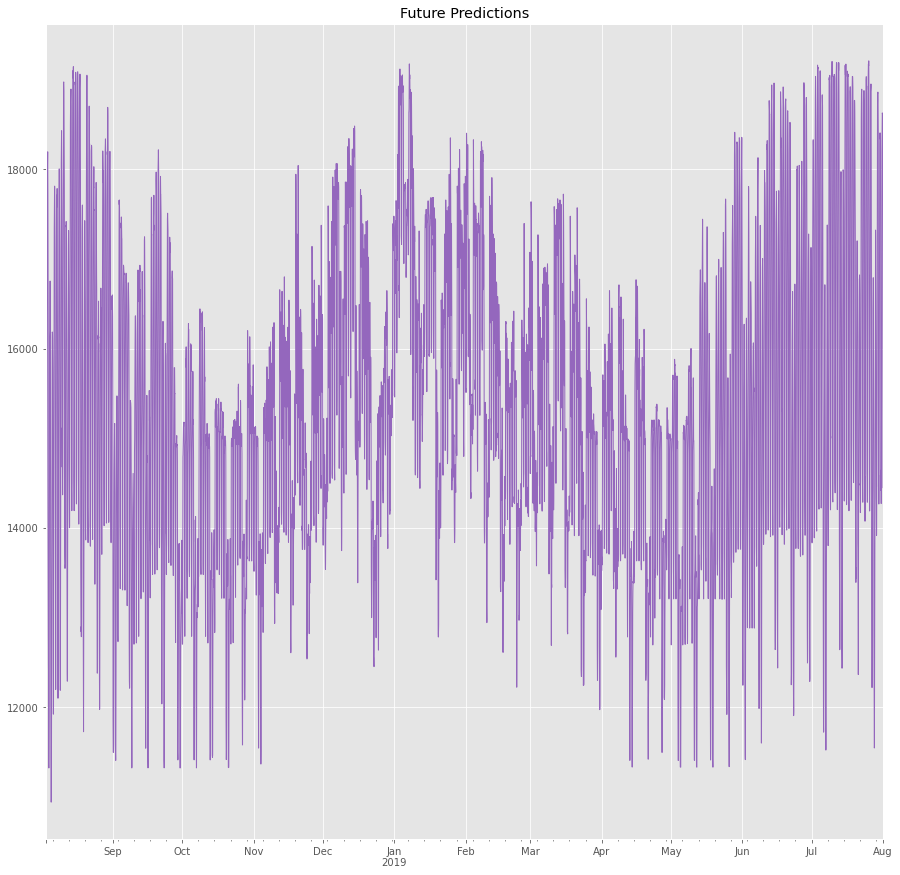

In [40]:
future_w_features['pred'].plot(figsize=(15,15), color=color_pal[4], ms=1, lw=1, title='Future Predictions')

In [ ]:
future_w_features

In [42]:
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3,lag4,isFuture
Datetime,,,,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,NaN,NaN,NaN,NaN,False
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,NaN,NaN,NaN,NaN,False
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,NaN,NaN,NaN,NaN,False
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,NaN,NaN,NaN,NaN,False
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,NaN,NaN,NaN,NaN,False


In [45]:
df['pred'] = 'NaN'

In [46]:
df_and_future_predictions = pd.concat([df, future_w_features])
df_and_future_predictions['pred'] = df_and_future_predictions['pred'].astype('float64')

In [48]:
df_and_future_predictions.tail()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3,lag4,isFuture,pred
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,16579.0,18495.0,20026.0,NaN,True,18264.476562
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,16457.0,17771.0,19529.0,NaN,True,18309.089844
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,16197.0,17220.0,19029.0,NaN,True,18148.384766
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,15259.0,16100.0,17790.0,NaN,True,17103.419922
2019-08-01 00:00:00,NaN,0,3,3,8,2019,213,14125.0,14812.0,16247.0,NaN,True,14449.898438


In [49]:
df_and_future_predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 129319 entries, 2004-10-01 01:00:00 to 2019-08-01 00:00:00
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   AEP_MW     120606 non-null  float64
 1   hour       129319 non-null  int64  
 2   dayofweek  129319 non-null  int64  
 3   quarter    129319 non-null  int64  
 4   month      129319 non-null  int64  
 5   year       129319 non-null  int64  
 6   dayofyear  129319 non-null  int64  
 7   lag1       120016 non-null  float64
 8   lag2       111320 non-null  float64
 9   lag3       102767 non-null  float64
 10  lag4       120011 non-null  float64
 11  isFuture   129319 non-null  bool   
 12  pred       8713 non-null    float64
dtypes: bool(1), float64(6), int64(6)
memory usage: 12.9 MB


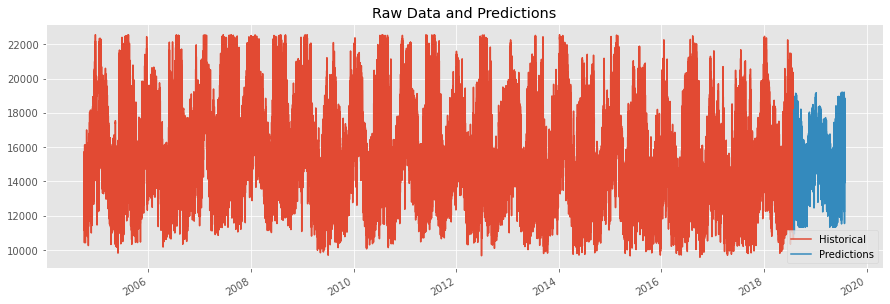

In [57]:
ax = df_and_future_predictions[['AEP_MW']].plot(figsize=(15, 5))
df_and_future_predictions['pred'].plot(ax=ax)
plt.legend(['Historical', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.savefig('Images/Raw_Data_and_Predictions.png')
plt.show()